In [124]:
import pandas as pd

benchmarks = [ "speech-tag", "text-to-p",  "shakespearean-writing-assistant", "sentence-rewrite", "extract-names", "elements", "art-prompt", "classify-input-text"   ]
prettyNames = { "speech-tag": "speech-tag", 
                "text-to-p": "text-to-p",  
                "shakespearean-writing-assistant": "shakespeare", 
                "sentence-rewrite": "sentence", 
                "extract-names": "extract-names", 
                "elements":"elements", 
                "art-prompt": "art-prompt", 
                "classify-input-text": "classify"}


### Add proper columns to the dataframe

data = {}
comp_val = {}
base_comp_val = {}
pos_comp_val = {}
neg_comp_val = {}

for benchmark in benchmarks:
    data[benchmark] = pd.read_csv(f'v7.2/{benchmark}/overview.csv')
    db = data[benchmark]
    
    db["compliant %"] = [float(p.strip('%')) / 100 for p in db["tests compliant"]]
    db["baseline %"] = [float(p.strip('%')) / 100 for p in db["baseline compliant"]]
    db["pos rule %"] = db["tests positive compliant"] / db["tests positive"]
    db["neg rule %"] = db["tests negative compliant"] / db["tests negative"]
    
    comp_val[benchmark] = db["compliant %"]
    base_comp_val[benchmark] = db["baseline %"]
    pos_comp_val[benchmark] = db["pos rule %"]
    neg_comp_val[benchmark] = db["neg rule %"]
    
    #print(db["compliant %"])
    #print(db["baseline %"])
    #print(db["pos rule %"])
    #print(db["neg rule %"])


# zero out the sum
n_models = len(data[benchmarks[0]]["model"])
comp_val["sum"] = [0 for i in range(n_models)]
base_comp_val["sum"] = [0 for i in range(n_models)]
pos_comp_val["sum"] = [0 for i in range(n_models)]
neg_comp_val["sum"] = [0 for i in range(n_models)]

# sum up the values across the benchmarks
for key in comp_val:
    if (key != "sum"):
        comp_val["sum"] = comp_val["sum"] + comp_val[key]
        base_comp_val["sum"] = base_comp_val["sum"] + base_comp_val[key]
        pos_comp_val["sum"] = pos_comp_val["sum"] + pos_comp_val[key]
        neg_comp_val["sum"] = neg_comp_val["sum"] + neg_comp_val[key]

# calculate the mean
comp_val["mean"] = comp_val["sum"]/len(benchmarks)
base_comp_val["mean"] = base_comp_val["sum"]/len(benchmarks)
pos_comp_val["mean"] = pos_comp_val["sum"]/len(benchmarks)
neg_comp_val["mean"] = neg_comp_val["sum"]/len(benchmarks)
    
### Generate a csv with the compliance % per benchmark for promptpex
###
    
with open('pp-cpct.csv', 'w') as cfile:
    print("Benchmark,", end="", file=cfile)
    print(', '.join(map(str, db["model"])), file=cfile)
        
    for benchmark in benchmarks:
        print(prettyNames[benchmark], ",", end="", file=cfile)
        db = data[benchmark]
        print(', '.join(map(str, db["compliant %"])), file=cfile)
    
    print("average", ",", end="", file=cfile)
    print(', '.join(map(str, comp_val["mean"])), file=cfile)

### Generate a csv comparing positive and negative compliance
###

with open('pos-neg-cpct.csv', 'w') as cfile:
    
    models = data[benchmarks[0]]["model"]
    pos_sum = [0 for i in range(len(models))]
    neg_sum = [0 for i in range(len(models))]    
    
    print("Benchmark, Rule % Compliance, Inv Rule % Compliance", file=cfile)

    for b in benchmarks:
        db = data[b]
        #print(db["pos rule %"])
        pos_sum += db["pos rule %"]
        neg_sum += db["neg rule %"]
            
    print(len(models))
    for m, psum, nsum in zip(models, pos_sum, neg_sum):
        print(m, ",", psum/len(benchmarks), ",", nsum/len(benchmarks), file=cfile)
        
    
    #print("average", ",", end="", file=cfile)
    #print(pos_comp_val["mean"], ",", neg_comp_val["mean"], file=cfile)

### Generate a csv with the average compliance of promptpex versus baseline
# each row is a model
# each column is a method (pp vs baseline)

with open('pp-compare.csv', 'w') as cfile:
    print("Benchmark, PromptPex, Baseline,", end="", file=cfile)



4


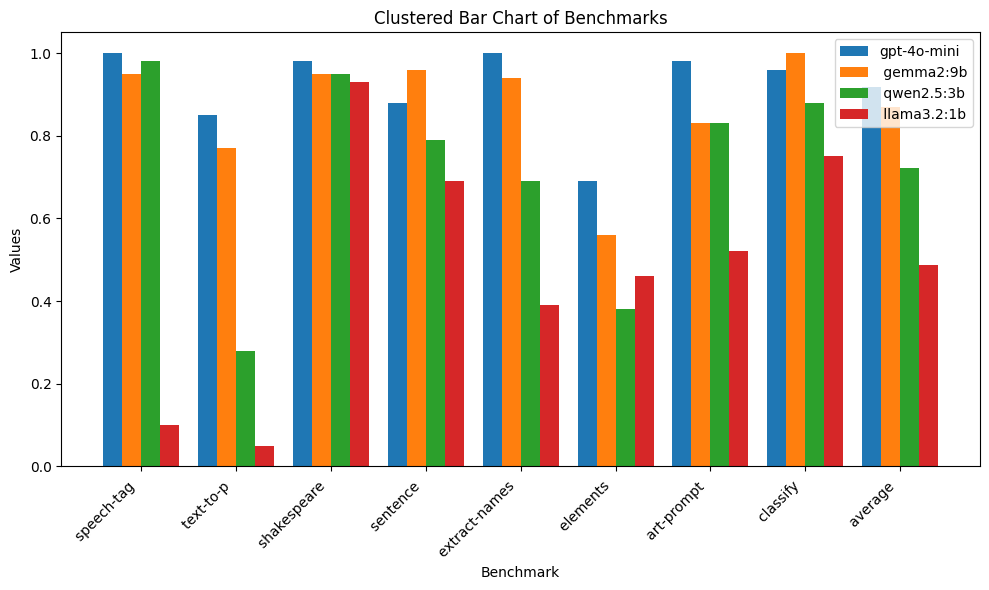

In [125]:
import matplotlib.pyplot as plt
import numpy as np

# Load the CSV file into a DataFrame
df = pd.read_csv('pp-cpct.csv')

# Remove the 'average' row if present
df = df[df['Benchmark'] != 'average']

# Set the 'Benchmark' column as the index
df.set_index('Benchmark', inplace=True)

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Number of benchmarks
n_benchmarks = len(df.index)
# Number of models
n_models = len(df.columns)

# Bar width
bar_width = 0.2

# Positions of the bars on the x-axis
indices = np.arange(n_benchmarks)

# Plot each model's bars
for i, model in enumerate(df.columns):
    ax.bar(indices + i * bar_width, df[model], bar_width, label=model)

# Set the x-axis labels
ax.set_xticks(indices + bar_width * (n_models - 1) / 2)
ax.set_xticklabels(df.index, rotation=45, ha='right')

# Set labels and title
ax.set_xlabel('Benchmark')
ax.set_ylabel('Values')
ax.set_title('Clustered Bar Chart of Benchmarks')
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()

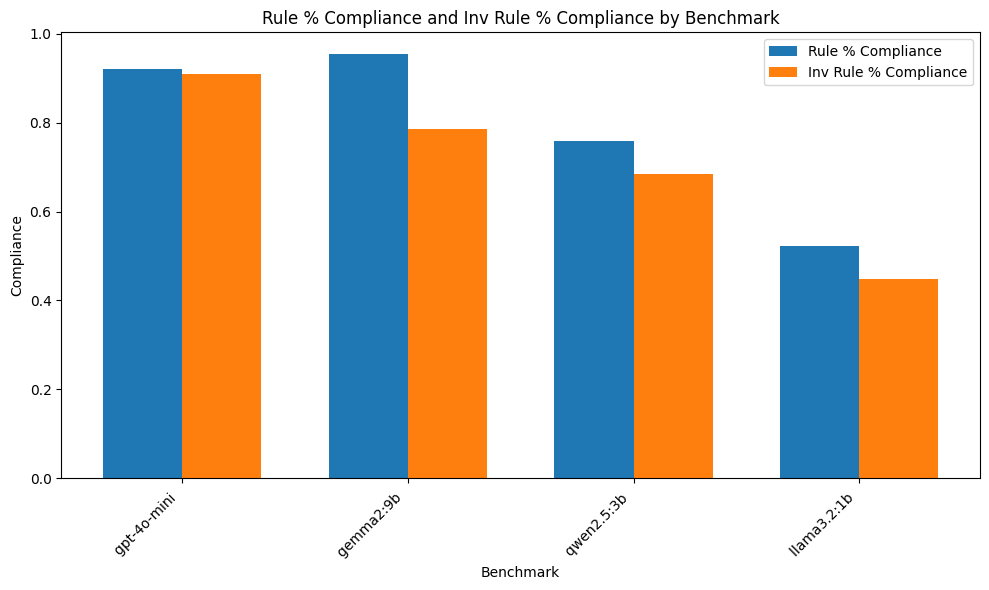

In [126]:
# Load the CSV file into a DataFrame
df = pd.read_csv('pos-neg-cpct.csv')

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Bar width
bar_width = 0.35

# Positions of the bars on the x-axis
indices = range(len(df))

# Plot each compliance type's bars
ax.bar(indices, df[' Rule % Compliance'], bar_width, label='Rule % Compliance')
ax.bar([i + bar_width for i in indices], df[' Inv Rule % Compliance'], bar_width, label='Inv Rule % Compliance')

# Set the x-axis labels
ax.set_xticks([i + bar_width / 2 for i in indices])
ax.set_xticklabels(df['Benchmark'], rotation=45, ha='right')

# Set labels and title
ax.set_xlabel('Benchmark')
ax.set_ylabel('Compliance')
ax.set_title('Rule % Compliance and Inv Rule % Compliance by Benchmark')
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()